In [ ]:
%pip install diffusers torch ipywidgets jupyter matplotlib pathlib requests

unet_path = ".cache/models--gnokit--ddpm-butterflies-64/snapshots/392181eaf40820b6e33dfd30a950ce0b6df46063/unet"

Boilerplate code:

* Import libraries
* Load the model to memory/GPU
* Define functions for extracting weights and biases

In [10]:
from torch.nn.functional import linear, silu, conv2d, group_norm, scaled_dot_product_attention, interpolate
from safetensors.torch import load_file
import torch
import os
import torch
import math
from tqdm.auto import tqdm
from PIL.Image import fromarray
from pathlib import Path
import requests
import hashlib


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.autograd.set_grad_enabled(False)

model_file_path = os.path.join(
    unet_path, "diffusion_pytorch_model.fp16.safetensors")

if (not Path(model_file_path).exists()):
    Path(unet_path).mkdir(parents=True, exist_ok=True)
    model_url = "https://huggingface.co/gnokit/ddpm-butterflies-64/resolve/main/unet/diffusion_pytorch_model.fp16.safetensors"
    try:
        response = requests.get(model_url)
        with open(model_file_path, "wb") as f:
            f.write(response.content)
    except Exception as e:
        Path(model_file_path).unlink()
        raise e

tensors = load_file(model_file_path)


def weight_bias(tensors, prefix):
    return tuple(tensors.get(f"{prefix}.{suffix}") for suffix in ["weight", "bias"])


def resnet_wb(tensors, prefix):
    return tuple(weight_bias(tensors, f"{prefix}.{suffix}") for suffix in ("norm1", "conv1", "time_emb_proj", "norm2", "conv2", "conv_shortcut"))


def attn_wb(tensors, prefix):
    return tuple(weight_bias(tensors, f"{prefix}.{suffix}") for suffix in ("group_norm", "to_q", "to_k", "to_v", "to_out.0"))


def get_image(image):
    return fromarray(((image.permute((2, 0, 3, 1)).flatten(1, 2) / 2 + 0.5).clamp(0, 1) * 255).cpu().numpy().astype("uint8"))

Code for the DDPM model proper.

For brevity, many of the model hyperparameters are hardcoded.

In [11]:
def get_t_emb(timestep):
    embeddings = timestep * torch.exp(-math.log(10000) * torch.arange(32) / 32)
    return torch.cat((torch.cos(embeddings), torch.sin(embeddings)), dim=-1)


def resnet(input, t_emb, norm1, conv1, time_emb_proj, norm2, conv2, conv_shortcut):
    hidden_states = conv2d(
        silu(group_norm(input, 32, *norm1)), *conv1, padding=1)
    t_emb = linear(t_emb, *time_emb_proj)[:, :, None, None]
    hidden_states = conv2d(
        silu(group_norm(hidden_states + t_emb, 32, *norm2)), *conv2, padding=1)
    input = conv2d(
        input, *conv_shortcut) if conv_shortcut[0] is not None else input

    return hidden_states + input


def attn(hidden_states, gn, to_q, to_k, to_v, to_out):
    head_dim = 8
    residual = hidden_states
    batch_size, channel, height, width = hidden_states.shape
    hidden_states = group_norm(
        hidden_states, 32, *gn).view(batch_size, channel, height * width).transpose(1, 2)
    heads = to_k[1].shape[-1] // head_dim
    q = linear(hidden_states, *to_q).view(batch_size, -
                                          1, heads, head_dim).transpose(1, 2)
    k = linear(hidden_states, *to_k).view(batch_size, -
                                          1, heads, head_dim).transpose(1, 2)
    v = linear(hidden_states, *to_v).view(batch_size, -
                                          1, heads, head_dim).transpose(1, 2)
    return linear(
        scaled_dot_product_attention(q, k, v).
        transpose(1, 2).
        reshape(batch_size, -1, heads * head_dim), *to_out).\
        transpose(-1, -2).reshape(batch_size,
                                  channel, height, width) + residual


def forward_down_block(hidden_states, down_block, t_emb, tensors):
    output_states = ()
    for layer in range(2):
        hidden_states = resnet(
            hidden_states, t_emb, *resnet_wb(tensors, f"down_blocks.{down_block}.resnets.{layer}"))
        attn_params = attn_wb(tensors,
                              f"down_blocks.{down_block}.attentions.{layer}")
        if (attn_params[0][0] is not None):
            hidden_states = attn(hidden_states, *attn_params)
        output_states += (hidden_states,)
    downsamplers_conv = weight_bias(
        tensors, f"down_blocks.{down_block}.downsamplers.0.conv")
    if (downsamplers_conv[0] is not None):
        hidden_states = conv2d(
            hidden_states, *downsamplers_conv, stride=2, padding=1)
        output_states += (hidden_states,)
    return hidden_states, output_states


def forward_down(hidden_states, t_emb, tensors):
    down_block_res_samples = (hidden_states,)
    for down_block in range(4):
        hidden_states, output_states = forward_down_block(
            hidden_states, down_block, t_emb, tensors)
        down_block_res_samples += output_states
    return hidden_states, down_block_res_samples


def forward_mid(hidden_states, t_emb, tensors):
    hidden_states = resnet(hidden_states, t_emb, *
                           resnet_wb(tensors, "mid_block.resnets.0"))
    hidden_states = attn(
        hidden_states, *attn_wb(tensors, "mid_block.attentions.0"))
    hidden_states = resnet(hidden_states, t_emb, *
                           resnet_wb(tensors, "mid_block.resnets.1"))
    return hidden_states


def forward_up_block(hidden_states, up_block, t_emb, res_hidden_states_list, tensors):
    for layer, res_hidden_states in enumerate(reversed(res_hidden_states_list)):
        hidden_states = resnet(torch.cat([hidden_states, res_hidden_states], dim=1), t_emb, *resnet_wb(
            tensors, f"up_blocks.{up_block}.resnets.{layer}"))
        attn_params = attn_wb(
            tensors, f"up_blocks.{up_block}.attentions.{layer}")
        hidden_states = attn(
            hidden_states, *attn_params) if attn_params[0][0] is not None else hidden_states
    upsamplers_conv = weight_bias(
        tensors, f"up_blocks.{up_block}.upsamplers.0.conv")
    hidden_states = conv2d(interpolate(
        hidden_states, scale_factor=2.0, mode="nearest"), *upsamplers_conv, padding=1) if upsamplers_conv[0] is not None else hidden_states
    return hidden_states


def forward_up(hidden_states, t_emb, residuals, tensors):
    for up_block in range(4):
        block_residuals = residuals[-3:]
        residuals = residuals[:-3]
        hidden_states = forward_up_block(hidden_states, up_block, t_emb,
                                         block_residuals, tensors)
    return hidden_states


def unet(input, t, tensors):
    t_emb = silu(linear(silu(linear(get_t_emb(t),
                                    *weight_bias(tensors,
                                                 "time_embedding.linear_1"))),
                        *weight_bias(tensors, "time_embedding.linear_2"))[None, :])

    hidden_states, residuals = forward_down(
        conv2d(input, *weight_bias(tensors, "conv_in"), padding=1), t_emb, tensors)
    hidden_states = forward_mid(hidden_states, t_emb, tensors)
    hidden_states = forward_up(
        hidden_states, t_emb, residuals, tensors)
    hidden_states = conv2d(silu(group_norm(hidden_states, 32,
                                           *weight_bias(tensors, "conv_norm_out"))),
                           *weight_bias(tensors, "conv_out"), padding=1)
    return hidden_states


alphas_p = torch.cumprod(1 - torch.linspace(0.0001, 0.02, 1000), 0)


def step(current, noise, t, t2, generator=None, use_noise=True):
    x0 = ((current - (1 - alphas_p[t]) ** (0.5) * noise) / alphas_p[t] ** (0.5)).\
        clamp(-1, 1)
    x0_c = (alphas_p[t2] ** (0.5) *
                    (1 - alphas_p[t] / alphas_p[t2])) / (1 - alphas_p[t]) if t2 >= 0 else 1
    xt2_c = (alphas_p[t] / alphas_p[t2]) ** (0.5) * \
        (1 - alphas_p[t2]) / (1 - alphas_p[t]) if t2 >= 0 else 0
    x_t2 = x0_c * x0 + xt2_c * current

    creative_noise = (((1 - alphas_p[t2]) / (1 - alphas_p[t]) * (
        1 - alphas_p[t] / alphas_p[t2])).clamp(1e-20) ** 0.5) if t2 >= 0 and use_noise else 0
    return x_t2 + creative_noise * torch.randn(x_t2.shape, generator=generator, device=device)

Generate an image of a butterfly. We are using seeded random number generators for reproducibility.

In [ ]:
image_generator = torch.Generator(device=device).manual_seed(2025)
noise_generator = torch.Generator(device=device).manual_seed(2025)
image = torch.randn((1, 3, 64, 64), generator=image_generator, device=device)

for t in tqdm(list(reversed(range(1000)))):
    noise = unet(image, t, tensors)
    image = step(image, noise, t, t - 1, generator=noise_generator)

get_image(image)

Visualize temporal embeddings.

In [ ]:
from matplotlib import pyplot as plt

figure, a = plt.subplots()

t_emb = get_t_emb(torch.arange(1000)[:, None])
a.set_title("Nth dimension of the temporal embedding over first 100 timesteps")
line = a.plot(t_emb[:100, (2, 5, 10)].cpu().numpy(),
                 label=["x[2]", "x[5]", "x[10]"])
a.legend(loc="right");

Trying to predict the original image in one step.

In [ ]:
image_generator = torch.Generator(device=device).manual_seed(2025)

t = 999
image = torch.randn((1, 3, 64, 64), generator=image_generator, device=device)
noise = unet(image, t, tensors)
image = step(image, noise, t, 0)

get_image(image)

Generating images in SQL takes a lot of time. See what we get if we cheat and skip steps.

Generate ten images of butterflies using a simplified noise schedule.

In [ ]:
# Cheat and skip steps

image_generator = torch.Generator(device=device).manual_seed(2025)
noise_generator = torch.Generator(device=device).manual_seed(2025)
image = (torch.rand((1, 3, 64, 64), generator=image_generator, device=device) * 2 - 1) * 1.73

steps = [500, 250, 125, 60, 0]
for t, t2 in tqdm(list(zip(steps, steps[1:]))):
    noise = unet(image, t, tensors)
    image = step(image, noise, t, t2, noise_generator)

get_image(image)

Those so inclined can try to generate images using the original HuggingFace pipeline API.

In [ ]:
from diffusers import DDPMPipeline

generator = torch.Generator().manual_seed(42)

pipeline = DDPMPipeline.from_pretrained(
    "gnokit/ddpm-butterflies-64", use_safetensors=True, variant="fp16").to(device)
images = pipeline(batch_size=1, generator=generator).images

for idx, img in enumerate(images):
    display(img)

The image below was generated in SQL and saved in a JSON file

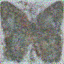

In [18]:
import json
with open("butterfly.json") as f:
    butterfly = torch.tensor(json.load(f))[None, :]
get_image(butterfly)